# Airbnb Listings in NYC

In this project, we will work with listings.csv which provides data on around 50,000 AirBnB listings in New York City. Our goal is to implement our own price suggestion model while keeping vacancy down.   

- Initial Data Exploration
- Data Cleaning and Formatting / EDA
- Modeling and Model Evaluatuation
- Result Interpretation

### Import Libraries

In [695]:
import csv
import pandas as pd
import numpy as np
import math
from math import log
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import collections
from collections import Counter
from PIL import Image
import re
import string

# Global variables
BNB_BLUE = '#007A87'
BNB_RED = '#FF5A5F'
BNB_DARK_GRAY = '#565A5C'
BNB_LIGHT_GRAY = '#CED1CC'
BROWN='#8B2323'
LIGT_GR='#C1FD95'

from sklearn import linear_model,metrics,preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV

from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import median_absolute_error,r2_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

# Initial Exploration


In [696]:
data = pd.read_csv('listings.csv')

data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews', 'reviews_per_month', 'price'],
      dtype='object')

In [697]:
#First 5 rows of the DataFrame:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews,reviews_per_month,price
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,2,288,46,0.39,225
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,3,1,365,0,NaN,150
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,1,1,212,274,4.64,89
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,10,1,0,9,0.10,80
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,3,1,127,75,0.60,200


In [698]:
#Number of rows and columns:
data.shape

(48864, 15)

In [699]:
#Index, Datatype and Memory information:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48864 entries, 0 to 48863
Data columns (total 15 columns):
id                                48864 non-null int64
name                              48848 non-null object
host_id                           48864 non-null int64
host_name                         48846 non-null object
neighbourhood_group               48864 non-null object
neighbourhood                     48864 non-null object
latitude                          48864 non-null float64
longitude                         48864 non-null float64
room_type                         48864 non-null object
minimum_nights                    48864 non-null int64
calculated_host_listings_count    48864 non-null int64
availability_365                  48864 non-null int64
number_of_reviews                 48864 non-null int64
reviews_per_month                 38733 non-null float64
price                             48864 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 5

Our data set contains 48864 rows of data. Each row is a specific listing on Airbnb in New york city. The 15 columns describe different attributes (features) of each listing:

- id
- name: Listing title
- host_id and host_name
- neighbourhood_group and neighbourhood
- latitude and longitude
- room_type: Entire home/apt, Private room or Shared room
- minimum_nights: Minimum number of nights a guest can stay for the rental
- calculated_host_listings_count: Number of other listings from the same host
- availability_365: Number of days the listing is avaialble during the year
- number_of_reviews: Number of reviews that previous guests have left
- reviews_per_month : Average number of reviews per month
- price: Price per night for the listing.

In [700]:
#Summary statistics for Numerical columns:
data.drop(['id','host_id'],axis=1).describe()

,latitude,longitude,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews,reviews_per_month,price
count,48864.000000,48864.000000,48864.000000,48864.000000,48864.000000,48864.000000,38733.000000,48864.000000
mean,40.728664,-73.951850,7.093116,7.438278,112.483505,23.392191,1.365694,151.453176
std,0.054794,0.046440,20.264170,34.949053,132.373994,44.939690,1.692891,236.585525
min,40.499790,-74.244420,1.000000,1.000000,0.000000,0.000000,0.010000,0.000000
25%,40.689797,-73.982952,1.000000,1.000000,0.000000,1.000000,0.190000,69.000000
50%,40.722880,-73.955510,2.000000,1.000000,41.000000,5.000000,0.710000,105.000000
75%,40.762970,-73.935628,5.000000,2.000000,232.000000,24.000000,2.000000,175.000000
max,40.912400,-73.712990,1250.000000,343.000000,365.000000,639.000000,66.610000,10000.000000


In [701]:
#Summary statistics for Categorical columns:
data.describe(include=['O'])

,name,host_name,neighbourhood_group,neighbourhood,room_type
count,48848,48846,48864,48864,48864
unique,47894,11407,5,222,3
top,Home away from home,Michael,Manhattan,Williamsburg,Entire home/apt
freq,19,430,21456,3915,25296


We can start by dropping id, since it is irrelevant for our study.


In [702]:
data.drop(columns=['id'],inplace=True)

                                       ~~

# Data cleaning + EDA
#### Missing Data

In [703]:
data.isna().sum() # columns with missing data

name                                 16
host_id                               0
host_name                            18
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
minimum_nights                        0
calculated_host_listings_count        0
availability_365                      0
number_of_reviews                     0
reviews_per_month                 10131
price                                 0
dtype: int64

We notice some missing values in name, host_name and review_per_month. All listings for which reviews_per_month is 0, have 0 total number of reviews. This means we can replace the null values with 0. We will drop host_name since host_id refers to the same host.

In [704]:
data.loc[data['reviews_per_month'].isnull(),"number_of_reviews"].describe()

count    10131.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: number_of_reviews, dtype: float64

In [705]:
data.loc[data['reviews_per_month'].isnull(),"reviews_per_month"]=0

data_v0=data.dropna(subset=['name']).drop('host_name',axis=1)

data_v0.columns

Index(['name', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'minimum_nights',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews', 'reviews_per_month', 'price'],
      dtype='object')

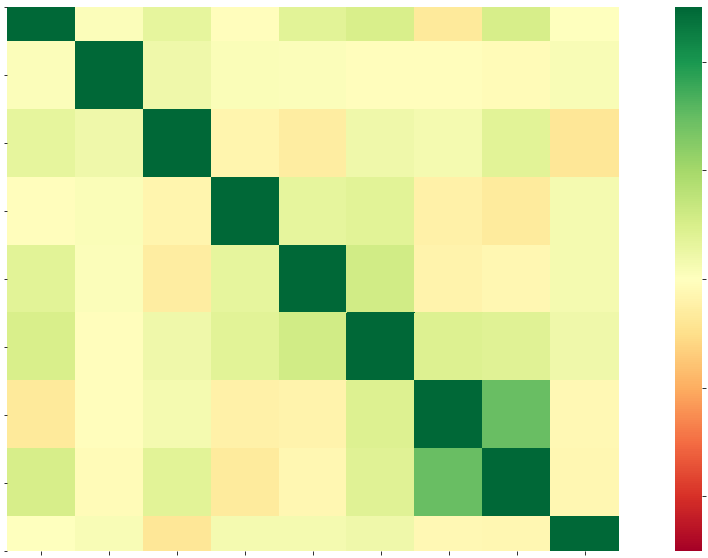

In [706]:
cor=data_v0.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(cor,  vmin=-1,vmax=1, square=True,annot=True, cmap="RdYlGn")
plt.show()

#### Numerical Data
##### - Listing Reviews

In [707]:
data_v0['reviews_per_month'].describe()

count    48848.000000
mean         1.082880
std          1.605835
min          0.000000
25%          0.040000
50%          0.370000
75%          1.560000
max         66.610000
Name: reviews_per_month, dtype: float64

75% of listings have less than 2 reviews per month, som have more than 30. We will drop the two listings that have more than 30 reviews per month. The maximum reasonable amount for this variable is 30.

In [708]:
data_v0.loc[data_v0['minimum_nights']==1,'reviews_per_month'].describe()
data_v1=data_v0[data_v0['reviews_per_month']<31]
len(data_v1)

48846

Since we don't have any rating data, we can't measure the popularity of listings and satisfaction of past guests. The closest metrics we have are reviews_per_month and number_of_reviews. Since these two variables are correlated because of their nature, we will use them to define a new metric: listing age (in months) as follows:

<h1><center> $Listing   Age$ = $\frac{Number of Reviews}{Reviews per Month}$  </center></h1>

This metric will give us the number of months a listing has been available and booked on airbnb. The review metrics are good indicators of guest satisfaction and listing popularity, since a listing with a lot of reviews (which usually means they are good ones) is more likely to be booked again and for the next guest to review it as well. Also a listing with high popularity means it is most likely reasonably priced.

In [709]:
data_v1[['number_of_reviews','reviews_per_month']]
data_v1['listing_age']=data_v1['number_of_reviews']/data_v1['reviews_per_month']
data_v1['listing_age']=data_v1['listing_age'].fillna(0)
data_v1['listing_age']

0        117.948718
1          0.000000
2         59.051724
3         90.000000
4        125.000000
            ...    
48859      0.000000
48860      0.000000
48861      0.000000
48862      0.000000
48863      0.000000
Name: listing_age, Length: 48846, dtype: float64

In [710]:
data_v1.drop(['reviews_per_month',"number_of_reviews"],axis=1,inplace=True)


##### - Minimum nights

In [711]:
data_v1['minimum_nights'].describe()

count    48846.000000
mean         7.074438
std         19.763479
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [712]:
(len(data_v1[data_v1['minimum_nights']>365])/len(data_v1))*100

0.024567006510256725

Airbnb does allow long term rentals. However, we will make the choice to drop listings for which minimum_nights is more than 365.

In [713]:
data_v1=data_v1[data_v1.minimum_nights<366]

#### Text Data
##### -  Listing names

In [714]:
data_v1['name'].value_counts()

Home away from home                                  19
Hillside Hotel                                       18
New york Multi-unit building                         15
Brooklyn Apartment                                   12
#NAME?                                               11
                                                     ..
Stunning Chelsea/West Vill. Floor Thru LOFT 4BEDs     1
Luxury 3 Bed in The Big Apple                         1
2  PRIVATE  ROOMS IN A  SPACIOUS APPARTEMENT          1
Yinka's Guest house                                   1
MODERN/ SUBWAY/TERRACE/LOFT/ LARGE MASTER BEDROOM     1
Name: name, Length: 47882, dtype: int64

In [715]:
len(data_v1.loc[data_v1['name']=="#NAME?",:])

11

In [716]:
data_v1.loc[data_v1['name']=="#NAME?",:]

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,calculated_host_listings_count,availability_365,price,listing_age
10068,#NAME?,31304940,Brooklyn,Williamsburg,40.71631,-73.96353,Private room,2,8,82,60,48.449612
10073,#NAME?,31304940,Brooklyn,Williamsburg,40.71692,-73.96353,Private room,2,8,89,60,47.846890
10083,#NAME?,31304940,Brooklyn,Williamsburg,40.71767,-73.96252,Private room,2,8,76,60,48.186528
10107,#NAME?,31304940,Brooklyn,Williamsburg,40.71714,-73.96234,Private room,2,8,103,60,48.275862
10117,#NAME?,31304940,Brooklyn,Williamsburg,40.71636,-73.96246,Private room,2,8,128,60,46.543779
10135,#NAME?,31304940,Brooklyn,Williamsburg,40.71544,-73.96211,Private room,2,8,97,60,48.095238
10467,#NAME?,31304940,Brooklyn,Williamsburg,40.71596,-73.96215,Private room,2,8,89,60,47.161572
10633,#NAME?,43298076,Manhattan,Harlem,40.82323,-73.95494,Private room,2,4,48,55,47.191011
12412,#NAME?,43298076,Manhattan,Harlem,40.82195,-73.95373,Private room,2,4,61,62,44.444444
27156,#NAME?,3464645,Manhattan,Hell's Kitchen,40.75575,-73.99374,Private room,2,3,150,130,20.370370


We have 11 "no name" listings that belong to 3 different hosts. We will drop those.

In [717]:
data_v2=data_v1[data_v1.name != "#NAME?"]
#data_v2.columns

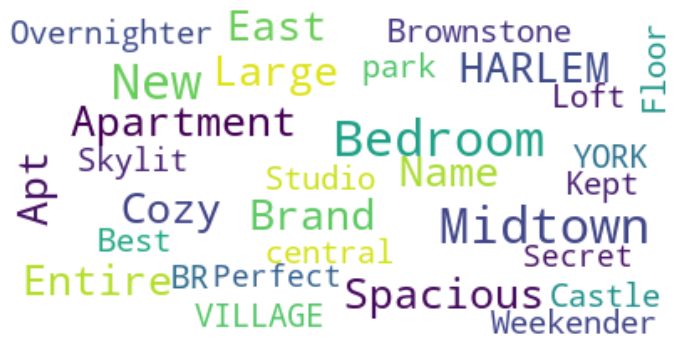

In [718]:
# Plotting a wordcloud
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title('Most used words in listing names', fontsize=18)
    plt.show()
    
listing_names=str(data_v2.name)
wd=WordCloud(max_font_size=30, max_words=30,background_color="white").generate(listing_names)
plot_wordcloud(wd, 'English')

Textual data is hard to use in models. This name variable is particularly hard to use because it is random, has different lengths and characters such as emojis, punctuation marks ..etc 
By splitting the words in listing names and counting frequencies, we came up with a list of the 500 most commonly used words. We will scan each listing title against this list, and attribute a score that counts how many popular words are used. We will name this metric: name_score and will use it instead of name.

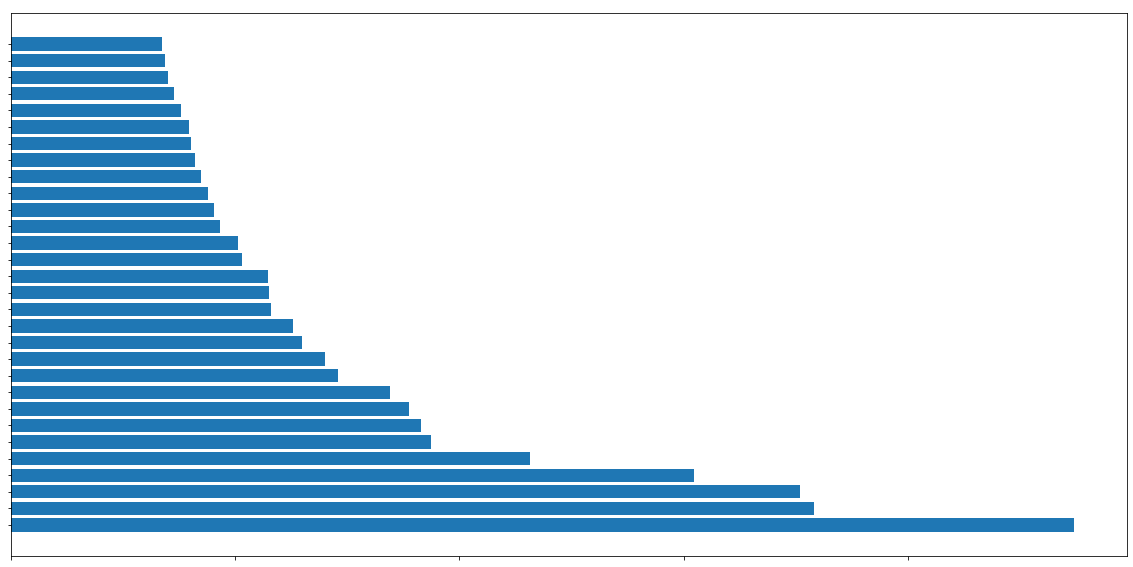

In [719]:
listing_names=data_v2.name.str.split().replace([',',')','(','-',''],"")

stopwords = STOPWORDS
stopwords = stopwords.union(set(['&','w', 'with', 'to', 'in','the','and','of',"-","a","+","(",")","1","2","3","4","5","6","7","8","!","/","your","#"]))

filtered_words = [word for word in listing_names]
filtered_words_result=[item for sublist in filtered_words for item in sublist]
filtered_words_result=[item.lower() for item in filtered_words_result]
filtered_words_result=[word for word in filtered_words_result if word not in stopwords]


counted_words = collections.Counter(filtered_words_result)

words = []
counts = []
for letter, count in counted_words.most_common(500):
    if letter not in stopwords:
        words.append(letter)
        counts.append(count)

rcParams['figure.figsize'] = 20, 10


plt.title('Top words in Listing Names vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words[:30], counts[:30])
plt.show()


In [720]:
def check_common_words(name):
    res=[]
    for word in name:
        word_lc=word.lower()
        if word_lc in words:
            res=res+ [word_lc.lower()]
    return res
#check_common_words(['brooklyn', 'random', 'cozy'])

In [721]:
data_v2['name_list']=data_v2['name'].apply(lambda x: x.split())
data_v2['name_list_common']=data_v2['name_list'].apply(check_common_words)

In [722]:
data_v2[['name_list','name_list_common']].head(15)

,name_list,name_list_common
0,"[Skylit, Midtown, Castle]",[midtown]
1,"[THE, VILLAGE, OF, HARLEM....NEW, YORK, !]","[village, york]"
2,"[Cozy, Entire, Floor, of, Brownstone]","[cozy, entire, floor, brownstone]"
3,"[Entire, Apt:, Spacious, Studio/Loft, by, cent...","[entire, spacious, central, park]"
4,"[Large, Cozy, 1, BR, Apartment, In, Midtown, E...","[large, cozy, br, apartment, midtown, east]"
5,[BlissArtsSpace!],[]
6,"[Large, Furnished, Room, Near, B'way]","[large, furnished, room, near]"
7,"[Cozy, Clean, Guest, Room, -, Family, Apt]","[cozy, clean, guest, room, family, apt]"
8,"[Best, Hideaway]","[best, hideaway]"
9,"[Cute, &, Cozy, Lower, East, Side, 1, bdrm]","[cute, cozy, lower, east, side, bdrm]"


In [723]:
data_v2['name_score']=data_v2['name_list_common'].apply(len)
data_v2['name_score'].describe()

count    48823.000000
mean         3.929767
std          1.593213
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         12.000000
Name: name_score, dtype: float64

In [724]:
data_v3=data_v2.drop(['name','name_list',
       'name_list_common'],axis=1)

In [725]:
data_v3.columns

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'minimum_nights',
       'calculated_host_listings_count', 'availability_365', 'price',
       'listing_age', 'name_score'],
      dtype='object')

#### Categorical Data
##### - Localisation data

In [726]:
data_v3.dtypes

host_id                             int64
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
minimum_nights                      int64
calculated_host_listings_count      int64
availability_365                    int64
price                               int64
listing_age                       float64
name_score                          int64
dtype: object

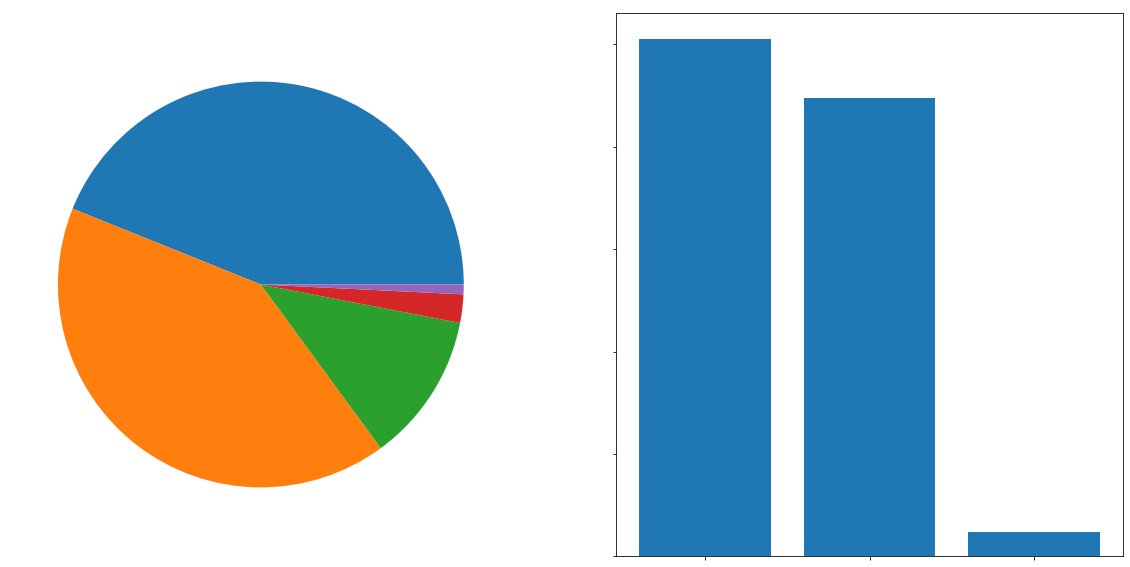

In [727]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(data_v3["neighbourhood_group"].value_counts(),labels=data_v3["neighbourhood_group"].value_counts().keys(),autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2);
ax1.set_title("Listings by Neighbourhood group")
ax2.bar(height=data_v3["room_type"].value_counts(),x=data_v3["room_type"].value_counts().keys())
ax2.set_title("Listings by Room Type")

plt.show()

Without surprise, the most popular neighborhood group is Manhattan (44%) followed very closely by Brooklyn(41%). The Most popular Room type is an Entire home/apt (52%) followed by a private room (46%). 
The least popular neighborhood group is Staten island (1%) and room type: shared room(2%).

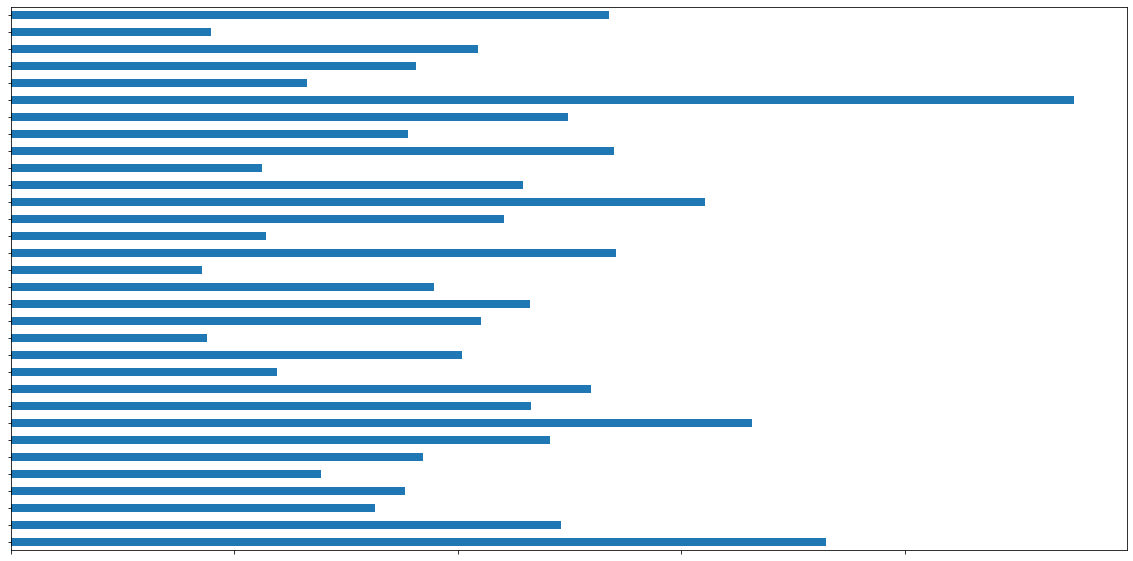

In [728]:
def plot_bar_neigh(neighbourhood):
    data_local=data_v3[data_v3.neighbourhood_group==neighbourhood]
    data_neihgbourhood=data_local.groupby(['neighbourhood_group','neighbourhood']).describe()['price']['mean']
    data_neihgbourhood[neighbourhood].plot.barh()
    plt.title("Price Average by neighborhood in " + neighbourhood)
    plt.xlabel("Price");
    
plot_bar_neigh("Manhattan")

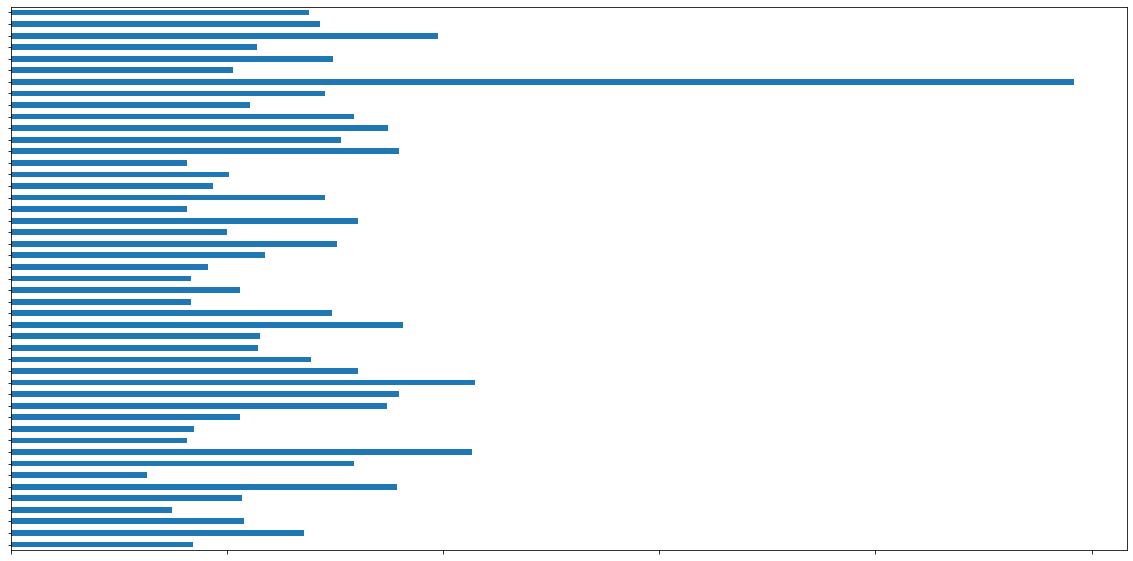

In [729]:
plot_bar_neigh("Brooklyn")

We have a few spatial variables: neighbourhood, neighbourhood_group, longitude, latitude. We will choose to drop Longitude and Latitude as it is not a very indication of listing price. Two listings can be in the same building/on the same street and have different costs depending on their sizes, capacity and interior design style.

We have other spatial variables that could be more interesting: Neighbourhood gives a first price window, the neighbourhood gives an even smaller one. It could be interesting to see what role they play in predicting a listing's price.

In [730]:
data_v4=data_v3.drop(['latitude','longitude'],axis=1)
data_v4.columns

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type',
       'minimum_nights', 'calculated_host_listings_count', 'availability_365',
       'price', 'listing_age', 'name_score'],
      dtype='object')

#### Listing prices
We will start by dropping free listings.


In [731]:
len(data_v4[data_v4['price']==0])
data_v4 = data_v4[data_v4.price > 0]
len(data_v4)

48813

First, let's have a look at listing price distribution across the city.

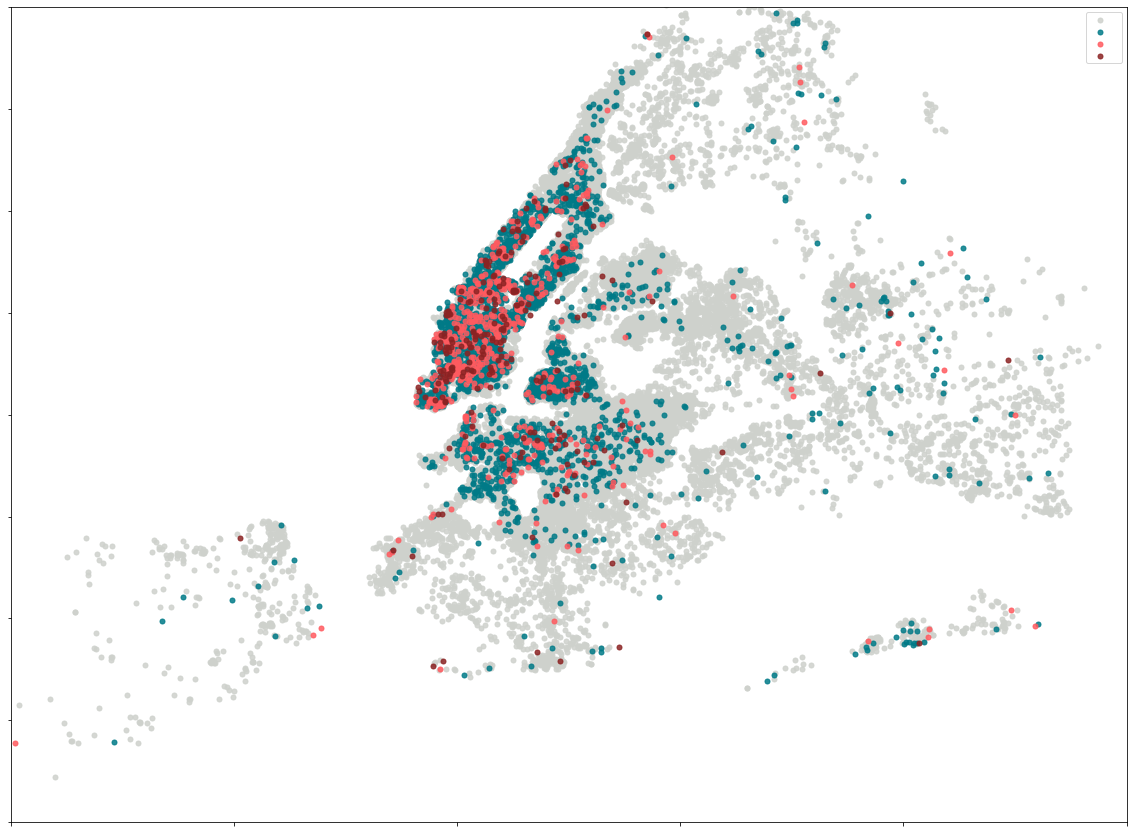

In [732]:
intervals = [0,250,500,1000,10000]

def plot_price_heatmap(data,intervals,target_var='price'):
    leg_labels = []

    # Get Labels for legend
    for i in range(0,len(intervals) - 1):
        if i == len(intervals) - 2:
            leg_labels.append('\${}+'.format(intervals[i]))
        else:
            leg_labels.append("\${}-\${}".format(intervals[i], intervals[i+1]))    

    buckets = []

    # Divide up into price buckets
    for i in range(0, len(intervals) - 1):
        buckets.append(data[(data[target_var] > intervals[i]) & (data[target_var] < intervals[i+1])])

    colors = [BNB_LIGHT_GRAY, BNB_BLUE, BNB_RED,BROWN]
    alphas = [0.85, 0.85, 0.85,0.85]  

    # Plot listings on scatterplot
    plt.figure(figsize=(20, 15))
    for i in range(0, len(buckets)):
        plt.scatter(buckets[i]['longitude'], buckets[i]['latitude'], alpha = alphas[i], c=colors[i], s=25)
    plt.title('NYC Airbnb Listings')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend(labels=leg_labels, loc = 'best')
    plt.xlim(-74.2,-73.7)
    plt.ylim(40.5,40.9)

    plt.show()
    
plot_price_heatmap(data_v3,intervals) #using data_v3 because we dropped long, lat in data_v4

We notice that most popular prices are below 250.However, we see a few listings in Manhattan and Brooklyn priced higher than 500. 
According to this map, it looks like the highest prices are concentrated below Central Park and above Prospect Park. Also, it is interesting to notice that dots of different colors overlap which confirms that the localisation is not an indicator of the price.

In [733]:
data_v4.price.describe()

count    48813.000000
mean       151.510827
std        236.686401
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

An IQR or z-score study on prices leads to a very small upper bound and a very tight window. If we define outliers using those methods, we will drop too many rows of data and decrease the quality of our data. Therefore, I have made the decision to set $500 as a reasonable value for the highest price. Any listing priced higher than that might not be the right fit for airbnb since it is a platform that caters to customers interested in affordable vacation/temporary housing that costs less than a hotel. If we had enough data of listings with high prices, we could split the dataset into affordable and luxury listings and study them separately.

We will make the choice to drop listings priced higher than 500 as only 0.5% of the listings cost more than $500.  

In [734]:
len(data_v4[data_v4.price>500])/len(data_v4)*100

2.024050970028476

In [735]:
data_v5=data_v4[data_v4.price<1000]

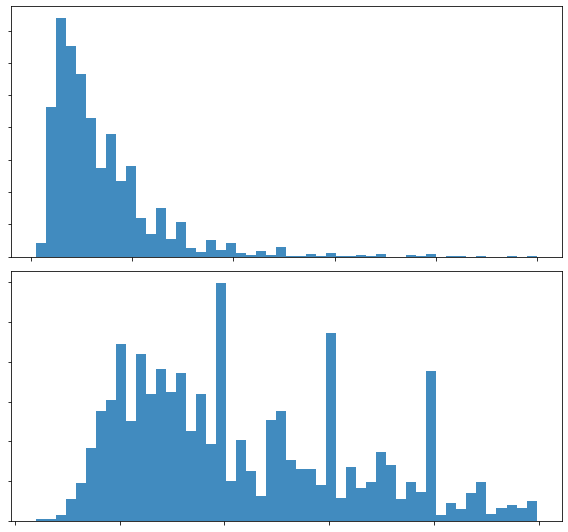

Skewness: 2.761743
Kurtosis: 11.635958


In [736]:
def plot_hist(n, titles, ranges):#n:integer for subplots,titles:list of titles,ranges:list of values
    fig, ax = plt.subplots(n, figsize = (8, 7.5))
    for i in range(n):
        d, bins, patches = ax[i].hist(ranges[i], 50, alpha = 0.85)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Daily Listing Price in Dollars")
        ax[i].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
prices = data_v5['price']

plot_hist(2, ['Distribution of Listing Prices: All Data', 
               'Distribution of Listing Prices: \$0 - \$250'], [prices, prices[prices < 250]])

print("Skewness: %f" % data_v5['price'].skew())
print("Kurtosis: %f" % data_v5['price'].kurt())

We see the distribution for pricing is strongly skewed. Airbnb does strongly cater to travelers who are looking for cheaper places to stay for short durations of time. 
Above we see that prices are right skewed - most listings cost below 250 a night. Examining the price bucket 0-250 (which has 75% of listings) we see that listings also tend to be most frequently priced at 50, 100, 150, and 200.

A few of the listing have extremely high prices. A transformation could likely reduce this skewness. Intuitively this matches with hosts that are listing a high value property such as an entire house in the more expensive parts of the city. To compensate for the skewed  distribution, we will log the response variable.

In [737]:
data_v5['price'].describe()

count    48529.000000
mean       139.522554
std        111.523576
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max        999.000000
Name: price, dtype: float64

In [738]:
#Log Transformation
log_price = data_v5['price'].apply(math.log)
data_v5['log_price'] = log_price
data_v5.drop(['price'],axis=1,inplace=True)

Skewness: 0.272014
Kurtosis: -0.104099


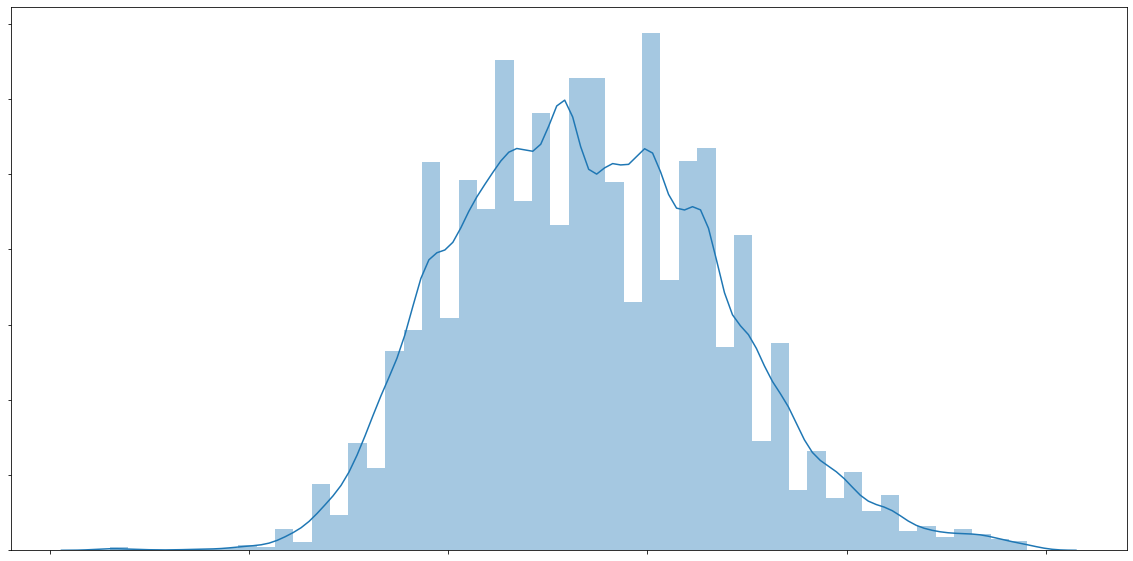

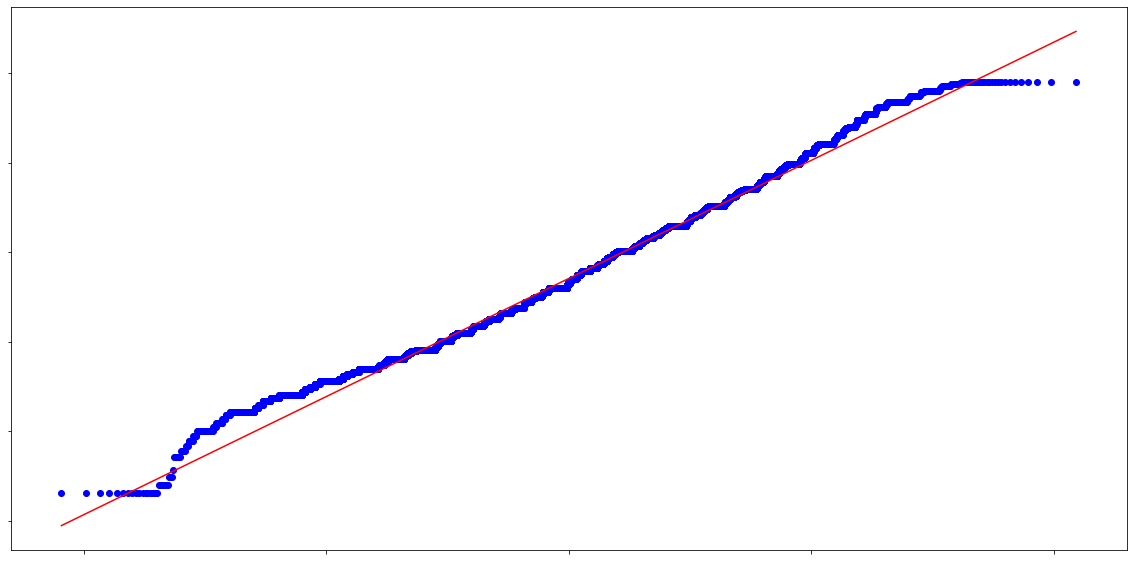

In [739]:
#histogram and normal probability plot
sns.distplot(data_v5['log_price']);
fig = plt.figure()
res = stats.probplot(data_v5['log_price'], plot=plt)

#skewness and kurtosis
print("Skewness: %f" % data_v5['log_price'].skew())
print("Kurtosis: %f" % data_v5['log_price'].kurt())


Log price is is still slightly right skewed but has a more symmetrical distribution. We can see visually that the price data more resembles a normal distribution. Our probability plot appears linear and reinforces our decision to leave log_price as-is.

We have made a lot of changes. Let's plot a correlation matrix to see if any variables are correlated. 


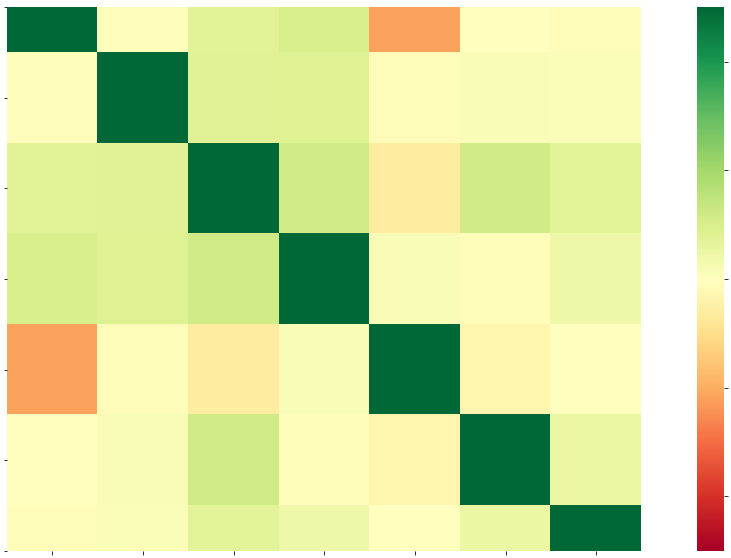

In [740]:
cor=data_v5.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(cor,  vmin=-1,vmax=1, square=True,annot=True, cmap="RdYlGn")
plt.show()

We see that host_id and listing_age have weak negative correlation(-0.43). This could be because newer hosts are given a new host_id (a higher value for host_id) and their listing is new (low value for listing_age). This correlation is not very significant and we will choose to ignore it.

Based on the correlation matrix output, there does not seem to be any obvious relationship between variables. 

In [741]:
len(data_v5)

48529

We have performed a good amount of data cleaning and formatting. Since we know the model we are using (Random Forest) requires very little input preparation, performs implicit feature selection and provides a pretty good indicator of feature importance, we will stop our Exploratory analysis here and start preparing the data for modeling.

# Modeling

#### Preparing Data for modelling: 

In [742]:
data_final=data_v5.copy()
target='log_price'
features= data_final.drop(target,axis=1).columns.tolist()


data_final[features].dtypes

host_id                             int64
neighbourhood_group                object
neighbourhood                      object
room_type                          object
minimum_nights                      int64
calculated_host_listings_count      int64
availability_365                    int64
listing_age                       float64
name_score                          int64
dtype: object

In [743]:
df_with_dummies = pd.get_dummies( data_final, columns = ['neighbourhood_group','neighbourhood','room_type'] )
df_with_dummies.columns

Index(['host_id', 'minimum_nights', 'calculated_host_listings_count',
       'availability_365', 'listing_age', 'name_score', 'log_price',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan',
       ...
       'neighbourhood_Williamsburg', 'neighbourhood_Willowbrook',
       'neighbourhood_Windsor Terrace', 'neighbourhood_Woodhaven',
       'neighbourhood_Woodlawn', 'neighbourhood_Woodrow',
       'neighbourhood_Woodside', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object', length=236)

In [744]:
X=df_with_dummies.drop(target,axis=1)
y=df_with_dummies[target]

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20)

Now that we have cleaned our data, we can examine different models and pick the most suitable one. We compare a few baseline models to more advanced ensemble methods. 


### Baseline Models
The three baseline models are Linear Regression, Ridge Regression, and Lasso Regression. 

#####  Linear Regression 

In this section, we take a look at which features correlate with the listing price of an Airbnb. We performed a basic ordinary least squares regression, predicting price using our variables.

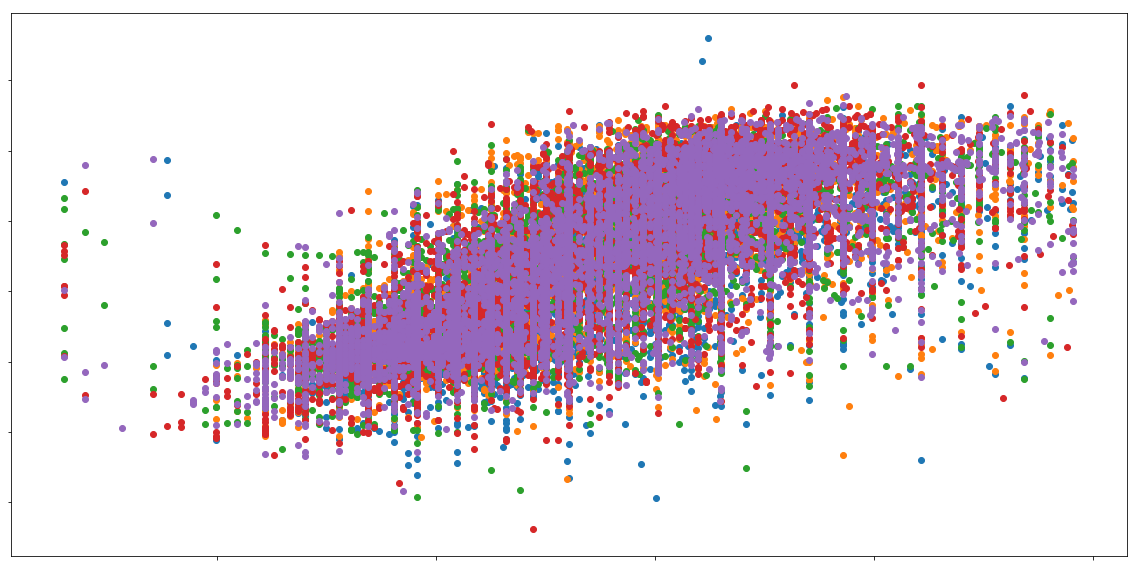

In [745]:
cv = KFold(n_splits = 5)
linreg = LinearRegression()

# Store r2 and median absolute error
MAE =[]
R2 = []

for train, test in cv.split(X):
    # Fit linreg
    linreg.fit(X.iloc[train], y.iloc[train])

    # Predict and score
    y_predict = linreg.predict(X.iloc[test])
    R2.append(linreg.score(X.iloc[test], y.iloc[test]))
    MAE.append(median_absolute_error(y.iloc[test], y_predict))
    plt.scatter(y.iloc[test],y_predict)
   # plt.xlim(2,9.5)
    #plt.ylim(2,9.5)
    plt.xlabel("y_test")
    plt.ylabel("y_predict")

# Output and store scores after CV
lin_testing_set_score = np.mean(R2)
lin_median_abs_error = np.mean(MAE)
plt.title("Linear Regression with K-Fold Cross Validation, R^2= %f"  %round(lin_testing_set_score,3));


##### Ridge Regression

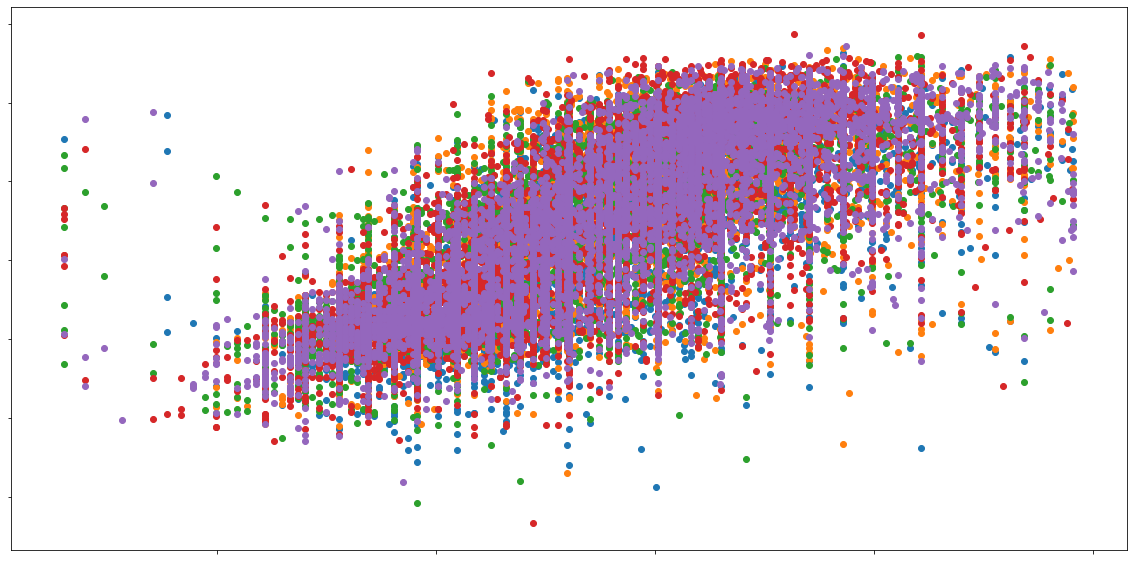

In [746]:
# Tuning paramater values for Ridge
lambdas = 10.**np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])

# Perform Ridge regression using expanded set of predictors, 

# choose best regularization parameter lambda using 5-fold x-validation
cv = KFold(n_splits = 5)
ridge = RidgeCV(alphas = lambdas, fit_intercept = False, normalize = True, cv = 5)

# Store r2 and median absolute error
MAE =[]
R2 = []

# Find best score by cross validating over 5 folds
for train, test in cv.split(X):
    # Fit ridge
    ridge.fit(X.iloc[train], y.iloc[train])
    
    # Predict and score
    y_predict = ridge.predict(X.iloc[test])
    R2.append(ridge.score(X.iloc[test], y.iloc[test]))
    MAE.append(median_absolute_error(y.iloc[test], y_predict))
    plt.scatter(y.iloc[test],y_predict)
    plt.xlabel("y_test")
    plt.ylabel("y_predict")

    
# Output and store scores after CV
ridge_testing_set_score = np.mean(R2)
ridge_median_abs_error = np.mean(MAE)
plt.title("Ridge Regression, R^2= %f"  %round(ridge_testing_set_score,3));


##### LASSO

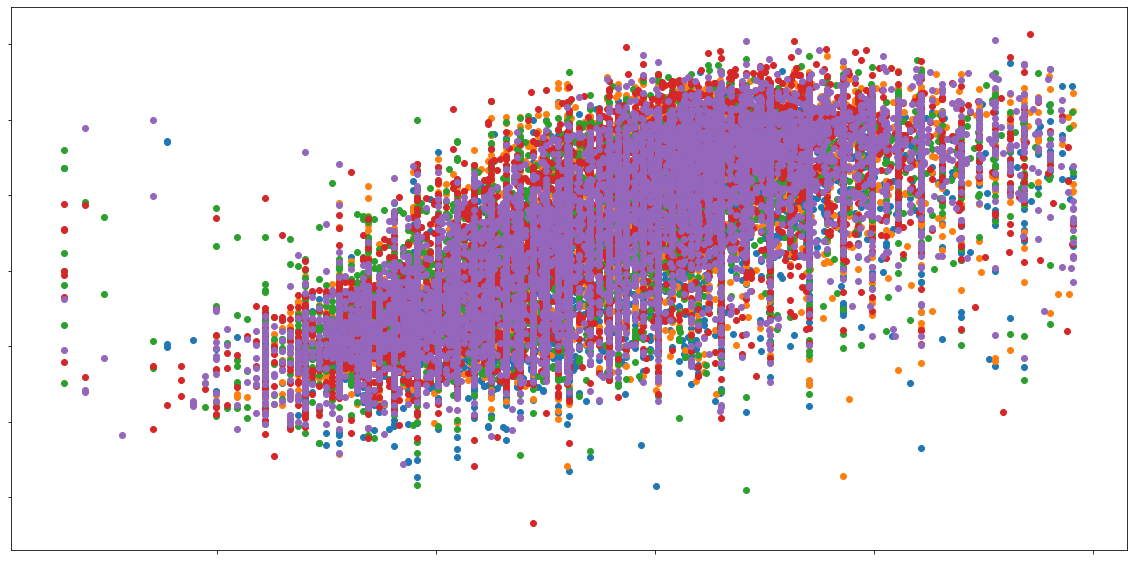

In [747]:
# Perform Lasso regression using expanded set of predictors, 
# choose best regularization parameter lambda using 5-fold x-validation
cv = KFold(n_splits = 5)
lasso = LassoCV(alphas = lambdas, tol = 0.01, fit_intercept = False, normalize = True, cv = 5)

# Store r2 and median absolute error
MAE =[]
R2 = []

# Find best score by cross validating over 5 folds
for train, test in cv.split(X):
    # Fit linreg
    lasso.fit(X.iloc[train], y.iloc[train])
    
    # Predict and score
    y_predict = lasso.predict(X.iloc[test])
    R2.append(lasso.score(X.iloc[test], y.iloc[test]))
    MAE.append(median_absolute_error(y.iloc[test], y_predict))
    plt.scatter(y.iloc[test],y_predict)
    plt.xlabel("y_test")
    plt.ylabel("y_predict")


# Output and store scores after CV
lasso_testing_set_score = np.mean(R2)
lasso_median_abs_error = np.mean(MAE)
plt.title("LASSO, R^2= %f"  %round(lasso_testing_set_score,3));


### 2) Ensemble Methods: 
Now we examine ensemble methods and see how they perform. 

#### Random Forest Regressor

We will first run a Random Forest Regression Model. It is a very powerful model that consists in averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of overcoming over-fitting problem of individual decision tree.

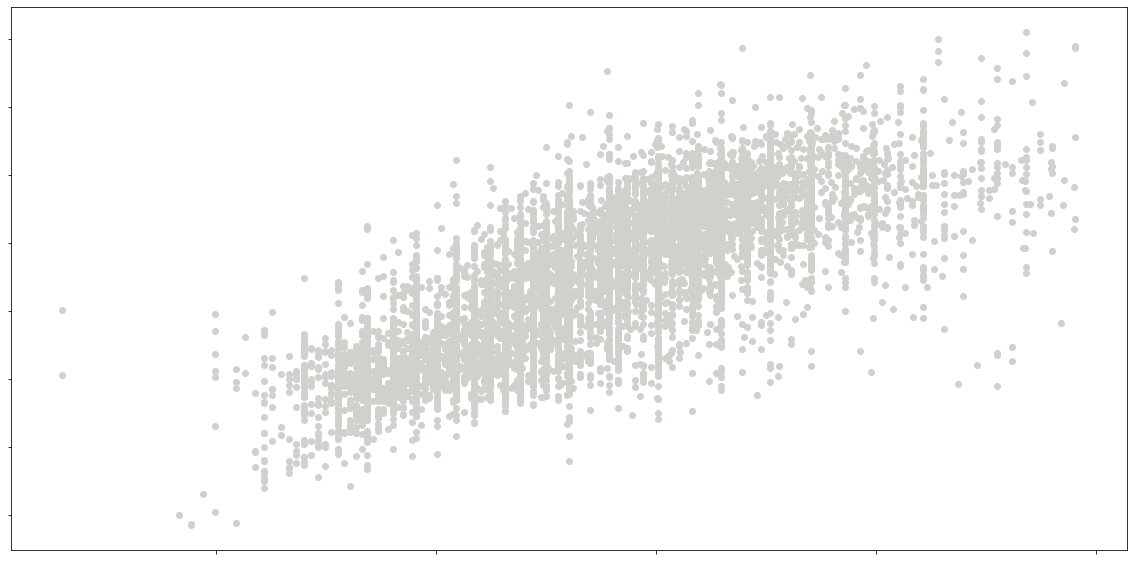

In [748]:
RF = RandomForestRegressor(oob_score = True,random_state=42)

# Fit the model
RF.fit(X_train, y_train)
# Predict using test data
y_pred=RF.predict(X_test)

plt.scatter(y_test,y_pred,color=BNB_LIGHT_GRAY)
plt.xlabel("y_test")
plt.ylabel("y_predict")

RF_median_abs_error = median_absolute_error(y_test, y_pred)

# Evaluate model
RF_testing_set_score=RF.score(X_test, y_test)
plt.title("Random Forest, R^2= %f"  %round(RF_testing_set_score,3));
plt.show();

In [749]:
importances = RF.feature_importances_
feature_importances = pd.DataFrame({"feature":X.columns.values, "importance":importances})
feature_importances.sort_values("importance", ascending=False).head(22)

,feature,importance
232,room_type_Entire home/apt,0.403503
0,host_id,0.107365
3,availability_365,0.073939
4,listing_age,0.073182
8,neighbourhood_group_Manhattan,0.067826
1,minimum_nights,0.048179
5,name_score,0.038636
2,calculated_host_listings_count,0.030824
138,neighbourhood_Midtown,0.011267
225,neighbourhood_Williamsburg,0.009860


#### Tuned Random Forest Regressor 

In [750]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickl

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickl

exception calling callback for <Future at 0x1a807e4910 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/soukainamoulahid/opt/anaconda3/l

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickl

exception calling callback for <Future at 0x1ce8527890 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/soukainamoulahid/opt/anaconda3/l

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickl

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickl

exception calling callback for <Future at 0x1a807691d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/soukainamoulahid/opt/anaconda3/l

exception calling callback for <Future at 0x1ce2bd0490 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/soukainamoulahid/opt/anaconda3/l

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickl

exception calling callback for <Future at 0x1cde3c64d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/soukainamoulahid/opt/anaconda3/l

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickl

exception calling callback for <Future at 0x1a807dd910 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/soukainamoulahid/opt/anaconda3/l

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickl

exception calling callback for <Future at 0x1cdd601190 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/soukainamoulahid/opt/anaconda3/l

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/soukainamoulahid/opt/anaconda3/lib/python3.7/pickl

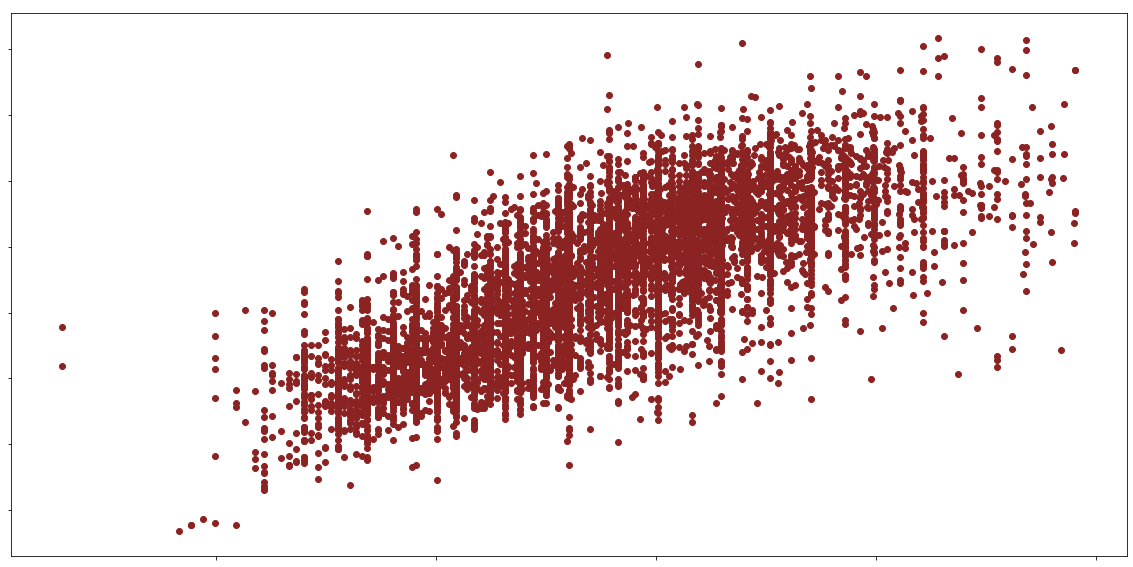

The best paramaters are: {'max_features': None, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': True}
The R^2 score on our testing data is: 0.586
The median absolute error on our testing data is: 0.247


In [751]:
# Parameters to run grid search on
tuned_parameters = {
    "n_estimators": [10, 30, 50],
    "n_jobs": [-1],
    "oob_score": [True],
    "max_features": [None, 'log2', 'auto']
}

# Run 3-fold CV grid search to tune hyperparameters
RF_tuned = GridSearchCV(RandomForestRegressor(), cv = 3, param_grid = tuned_parameters)

# Score model
preds = RF_tuned.fit(X_train, y_train)
best = RF_tuned.best_estimator_ 
y_predict = RF_tuned.predict(X_test)


plt.scatter(y_test,y_predict,color=BROWN)
plt.xlabel("y_test")
plt.ylabel("y_predict")



# Evaluate model
rft_testing_set_score = RF_tuned.score(X_test, y_test)
rft_median_abs_error = median_absolute_error(y_test, y_predict)

plt.title("Tuned Random Forest, R^2= %f"  %round(rft_testing_set_score,3));
plt.show();

# Output score and model info
print( 'The best paramaters are:', RF_tuned.best_params_)
print( 'The R^2 score on our testing data is: ' + str(round(rft_testing_set_score,3)))
print( 'The median absolute error on our testing data is: ' + str(round(rft_median_abs_error,3)))

Now we will use the following boosting algorithm : Adaboost.

#### AdaBoost Regressor (with Random Forest as Base Estimator)


In [ ]:
# Fit AdaBoost forest
ada = AdaBoostRegressor(base_estimator = RF)
ada.fit(X_train, y_train)

In [ ]:

# Predict and score adaboost
y_predict = ada.predict(X_test)
ada_testing_set_score = ada.score(X_test, y_test)
ada_median_abs_error = median_absolute_error(y_test, y_predict)


plt.scatter(y_test,y_predict)
plt.xlabel("y_test")
plt.ylabel("y_predict")
plt.xlim(2,9.5)
plt.ylim(2,9.5)

plt.title("AdaBoost Regressor with Random Forest, R^2= %f"  %round(ada_testing_set_score,3));
plt.show();


print( 'The R^2 score on our testing data is: ' + str(round(ada_testing_set_score,3)))
print ('The median absolute error on our testing data is: ' + str(round(ada_median_abs_error,3)))



Analysis of Model Results:


In [ ]:
# Graph x and y axis values
labels = np.array(['OLS','Ridge Tuned','Lasso Tuned', 'Random Forest', 'Tuned (Random Forest)', 'AdaBoost (Random Forest)'])
error_val = np.array([lin_testing_set_score, ridge_testing_set_score, lasso_testing_set_score, 
                      RF_testing_set_score, rft_testing_set_score, ada_testing_set_score])

median_abs_error=np.array([lin_median_abs_error, ridge_median_abs_error, lasso_median_abs_error, 
                      RF_median_abs_error, rft_median_abs_error, ada_median_abs_error])

eval_data=pd.DataFrame({'models':labels,'R2':error_val,'MAE':median_abs_error})
pos = np.arange(error_val.shape[0])

plt.figure(figsize=(10,5))
plt.bar(pos, eval_data['R2'], color = BNB_LIGHT_GRAY, width = 0.25,label="R^2")
plt.bar(pos+0.2, eval_data['MAE'], color = 'g', width = 0.25,label="Median Absolute Error")

plt.xticks(pos, labels[srt],rotation=45)
plt.title('$R^2$ and MAE  Model Comparison')
plt.legend()

plt.ylim(0,0.65)
plt.show()

As expected , Ensemble methods yield far better results, especially after proper tuning (using GridSearchCV).

Running an Tuned Random Forest on our data yields the best results out of all models. This is especially interesting considering that we did not tune AdaBoost, nor did we tune its base Random Forest estimator. 

It seems reasonable to believe that if I were to increase the number of estimators I would get more accurate results. However, I am not able to explore this possibility given the limited computational capacity at my disposal. 

Our Tuned Random Forest estimator had both the highest R^2 and lowest MAE, which shows that our method did prove effective in increasing accuracy.

In [694]:
predictions = np.expm1(predictions)


NameError: name 'predictions' is not defined